# Bayesian Linear Regression

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer.jl/examples`


In [82]:
using RxInfer, Random, Plots, StableRNGs, BenchmarkTools, LinearAlgebra, StatsPlots

## Univariate regression with known noise

In this example, we are going to perform a simple linear regression problem, but in the Bayesian setting. We specify the model's likelihood as:

$$\begin{aligned}
p(y_i) = \mathcal{N}(y_i | a * x_i + b , 1.0)
\end{aligned}$$

where $x_i$ and $y_i$ are observed values and $a$ and $b$ are random variables with the following priors:

$$\begin{aligned}
    p(a) &= \mathcal{N}(a|m_a, v_a) \\
    p(b) &= \mathcal{N}(b|m_b, v_b) 
\end{aligned}$$

In [3]:
@model function linear_regression(n)
    a ~ NormalMeanVariance(0.0, 1.0)
    b ~ NormalMeanVariance(0.0, 100.0)
    
    x = datavar(Float64, n)
    y = datavar(Float64, n)
    
    for i in 1:n
        y[i] ~ NormalMeanVariance(a * x[i] + b, 1.0)
    end
end

In order to test our inference procedure we create a test dataset where observations are corrupted with noise. During the inference procedure known variance we, however, do not know the exact magnitude of the noise.

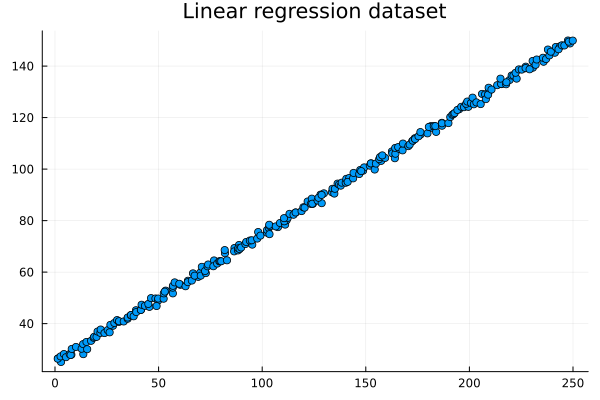

In [4]:
reala = 0.5
realb = 25.0
realv = 1.0

N = 250

rng = StableRNG(1234)

xorig = collect(1:N)

xdata = xorig .+ randn(rng, N)
ydata = rand.(NormalMeanVariance.(realb .+ reala .* xorig, realv))

scatter(xdata, ydata, title = "Linear regression dataset", legend=false)

In order to run inference with the static dataset we use the `inference` function from `RxInfer` package.

In [5]:
results = inference(
    model = linear_regression(length(xdata)), 
    data  = (y = ydata, x = xdata), 
    initmessages = (b = NormalMeanVariance(0.0, 100.0), ), 
    returnvars   = (a = KeepLast(), b = KeepLast()), 
    iterations = 20,
);

After the inference has been completed it is interesting to compare prior distribution and posterior distribution against the real values:

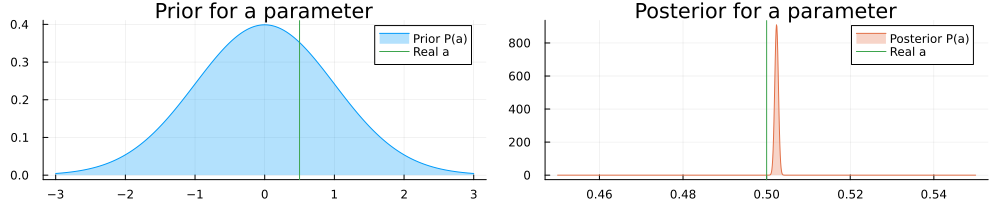

In [6]:
pra = plot(range(-3, 3, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 1.0), x), title="Prior for a parameter", fillalpha=0.3, fillrange = 0, label="Prior P(a)", c=1,)
pra = vline!(pra, [ reala ], label="Real a", c = 3)
psa = plot(range(0.45, 0.55, length = 1000), (x) -> pdf(results.posteriors[:a], x), title="Posterior for a parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(a)", c=2,)
psa = vline!(psa, [ reala ], label="Real a", c = 3)

plot(pra, psa, size = (1000, 200))

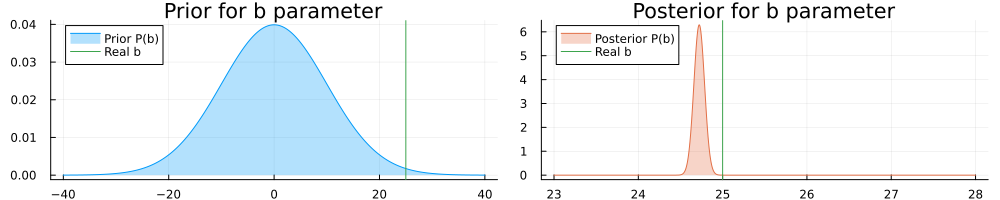

In [7]:
prb = plot(range(-40, 40, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 100.0), x), title="Prior for b parameter", fillalpha=0.3, fillrange = 0, label="Prior P(b)", c=1, legend = :topleft)
prb = vline!(prb, [ realb ], label="Real b", c = 3)
psb = plot(range(23, 28, length = 1000), (x) -> pdf(results.posteriors[:b], x), title="Posterior for b parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(b)", c=2, legend = :topleft)
psb = vline!(psb, [ realb ], label="Real b", c = 3)

plot(prb, psb, size = (1000, 200))

In [8]:
a = results.posteriors[:a]
b = results.posteriors[:b]

println("Real a: ", reala, " | Estimated a: ", mean_var(a), " | Error: ", abs(mean(a) - reala))
println("Real b: ", realb, " | Estimated b: ", mean_var(b), " | Error: ", abs(mean(b) - realb))

Real a: 0.5 | Estimated a: (0.5023780887254143, 1.9152402435219974e-7) | Error: 0.00237808872541434
Real b: 25.0 | Estimated b: (24.722462680057774, 0.004015967531215887) | Error: 0.2775373199422262


We can see that ReactiveMP.jl estimated real values of linear regression coefficients with high precision. 

## Univariate regression with unknown noise

For this demo we are going to increase the amount of noise in the dataset, but also instead of using a fixed value for the noise in the model we are going to make it a random variable with its own prior:

$$\begin{aligned}
p(s) = \mathcal{IG}(s|\alpha, \theta)
\end{aligned}$$

In [9]:
@model function linear_regression_unknown_noise(n)
    a ~ NormalMeanVariance(0.0, 1.0)
    b ~ NormalMeanVariance(0.0, 100.0)
    s ~ InverseGamma(1.0, 1.0)
    
    x = datavar(Float64, n)
    y = datavar(Float64, n)
    
    for i in 1:n
        y[i] ~ NormalMeanVariance(a * x[i] + b, s)
    end
end

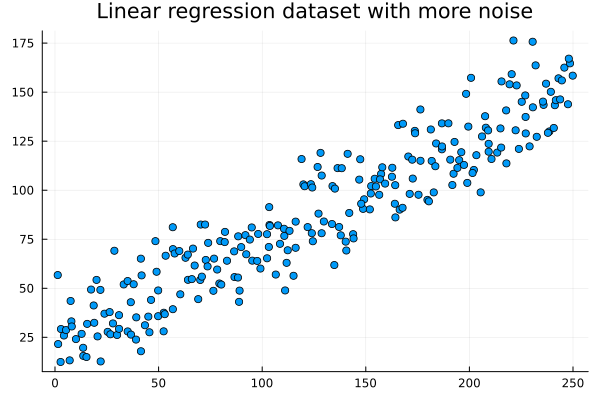

In [10]:
reala_un = 0.5
realb_un = 25.0
realv_un = 200.0

N_un = 250

rng_un = StableRNG(1234)

xorig_un = collect(1:N)

xdata_un = xorig_un .+ randn(rng_un, N_un)
ydata_un = rand.(NormalMeanVariance.(realb_un .+ reala_un .* xorig_un, realv_un))

scatter(xdata_un, ydata_un, title = "Linear regression dataset with more noise", legend=false)

To solve this problem analytically we need to set `constraints = MeanField()` as well as provide initial marginals with the `initmarginals` argument. We are also going to evaluate the convergency performance of the algorithm with the `free_energy = true` option:

In [11]:
results_unknown_noise = inference(
    model = linear_regression_unknown_noise(length(xdata_un)), 
    data  = (y = ydata_un, x = xdata_un), 
    initmessages = (b = NormalMeanVariance(0.0, 100.0), ), 
    returnvars   = (a = KeepLast(), b = KeepLast(), s = KeepLast()), 
    iterations = 20,
    constraints = MeanField(),
    initmarginals = (s = vague(InverseGamma), ),
    free_energy = true
);

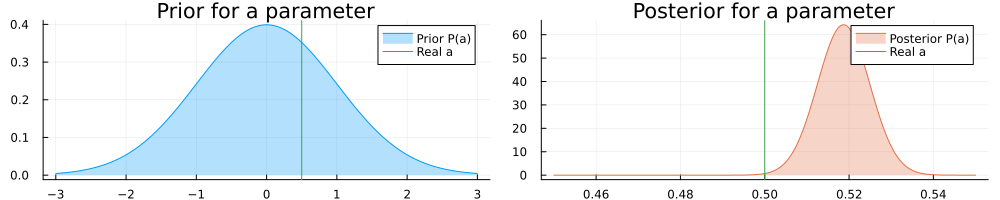

In [12]:
pra = plot(range(-3, 3, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 1.0), x), title="Prior for a parameter", fillalpha=0.3, fillrange = 0, label="Prior P(a)", c=1,)
pra = vline!(pra, [ reala_un ], label="Real a", c = 3)
psa = plot(range(0.45, 0.55, length = 1000), (x) -> pdf(results_unknown_noise.posteriors[:a], x), title="Posterior for a parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(a)", c=2,)
psa = vline!(psa, [ reala_un ], label="Real a", c = 3)

plot(pra, psa, size = (1000, 200))

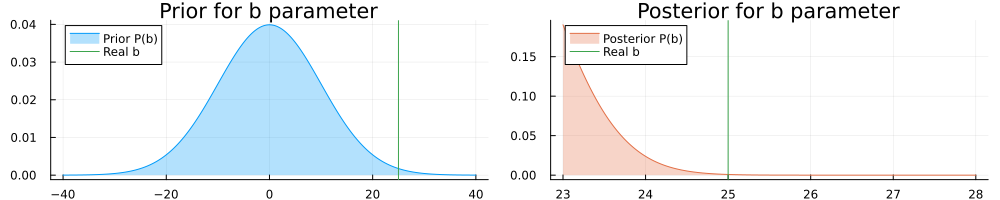

In [13]:
prb = plot(range(-40, 40, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 100.0), x), title="Prior for b parameter", fillalpha=0.3, fillrange = 0, label="Prior P(b)", c=1, legend = :topleft)
prb = vline!(prb, [ realb_un ], label="Real b", c = 3)
psb = plot(range(23, 28, length = 1000), (x) -> pdf(results_unknown_noise.posteriors[:b], x), title="Posterior for b parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(b)", c=2, legend = :topleft)
psb = vline!(psb, [ realb_un ], label="Real b", c = 3)

plot(prb, psb, size = (1000, 200))

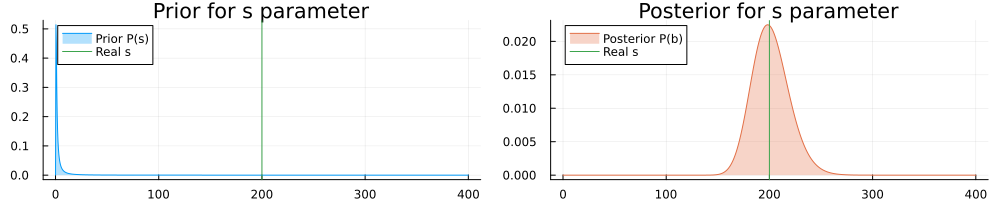

In [14]:
prb = plot(range(0.001, 400, length = 1000), (x) -> pdf(InverseGamma(1.0, 1.0), x), title="Prior for s parameter", fillalpha=0.3, fillrange = 0, label="Prior P(s)", c=1, legend = :topleft)
prb = vline!(prb, [ realv_un ], label="Real s", c = 3)
psb = plot(range(0.001, 400, length = 1000), (x) -> pdf(results_unknown_noise.posteriors[:s], x), title="Posterior for s parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(b)", c=2, legend = :topleft)
psb = vline!(psb, [ realv_un ], label="Real s", c = 3)

plot(prb, psb, size = (1000, 200))

We can see that in the presence of more noise the inference result is more uncertain about the actual values for $a$ and $b$ parameters.

Lets sample $a$ and $b$ and plot many regression lines on the same plot:

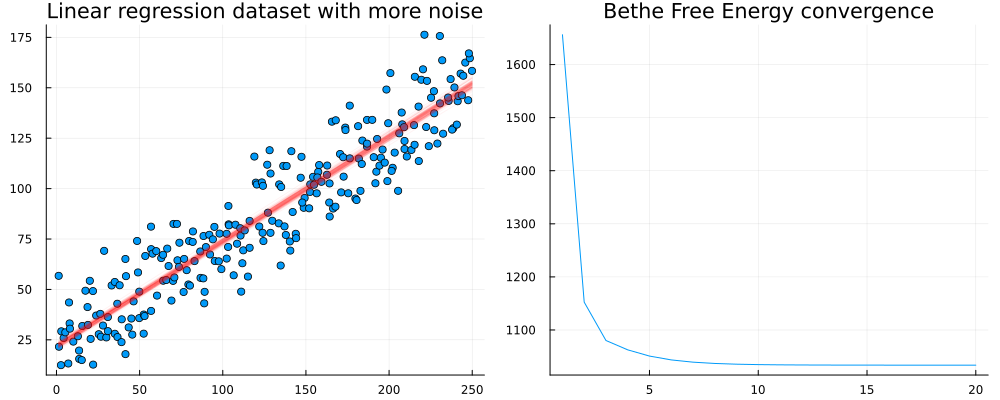

In [15]:
as = rand(results_unknown_noise.posteriors[:a], 100)
bs = rand(results_unknown_noise.posteriors[:b], 100)

p = scatter(xdata_un, ydata_un, title = "Linear regression dataset with more noise", legend=false)

for (a, b) in zip(as, bs)
    global p = plot!(p, xdata_un, a .* xdata_un .+ b, alpha = 0.05, color = :red)
end

f = plot(results_unknown_noise.free_energy, title = "Bethe Free Energy convergence", label = nothing)

plot(p, f, size = (1000, 400))

From this plot we can see that many lines do fit the data well and there is no definite "best" answer to the regression coefficients. Most of these lines, however, resemble a similar angle and shift. Bethe Free Energy plot on the right hand side indicates that the inference procedure converged normally.

## Multivariate linear regression

In this example we are essentially going to perform many linear regression tasks at once, using multiple `x` data vector and multiple `y` outputs with different noises. As in the previous example we assume noise to be unknown as well:

In [16]:
@model function linear_regression_multivariate(m, n)
    a ~ MvNormalMeanCovariance(zeros(m), 100 * diageye(m))
    b ~ MvNormalMeanCovariance(ones(m), 100 * diageye(m))
    W ~ InverseWishart(m + 2, 100 * diageye(m))

    # Here is a small trick to make the example work
    # We treat the `x` vector as a Diagonal matrix such that we can multiply it with `a`
    x = datavar(Diagonal{Float64, Vector{Float64}}, n)
    y = datavar(Vector{Float64}, n)
    z = randomvar(n)

    z .~ x .* a .+ b
    y .~ MvNormalMeanCovariance(z, W)

end

Lets have the following dataset, where multiple linear regression intersect with each other:

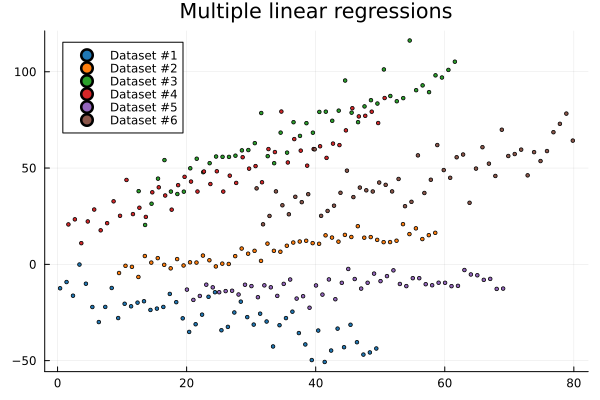

In [293]:

N_mv = 50
s_mv = floor(N_mv / 10)
d_mv = 6

rng_mv = StableRNG(42)

a_mv = randn(rng_mv, d_mv)
b_mv = 10 * randn(rng_mv, d_mv)
v_mv = 100 * rand(rng_mv, d_mv)

x_mv = []
y_mv = []

p = plot(title = "Multiple linear regressions", legend = :topleft)

plt = palette(:tab10)

for k in 1:d_mv
    x_mv_k = collect((1 + s_mv * (k - 1)):(N_mv + s_mv * (k - 1))) .+ 10 * randn()
    y_mv_k = rand.(NormalMeanVariance.(a_mv[k] .* x_mv_k .+ b_mv[k], v_mv[k]))

    global p = scatter!(p, x_mv_k, y_mv_k, label = "Dataset #$k", ms = 2, color = plt[k])

    push!(x_mv, x_mv_k)
    push!(y_mv, y_mv_k)
end

p

In [294]:
xdata_mv = map(i -> Diagonal(getindex.(x_mv, i)), 1:N_mv)
ydata_mv = map(i -> getindex.(y_mv, i), 1:N_mv);

In [295]:
results_mv = inference(
    model = linear_regression_multivariate(d_mv, N_mv),
    data  = (y = ydata_mv, x = xdata_mv),
    initmarginals = (W = InverseWishart(d_mv + 2, 10 * diageye(d_mv)), ),
    initmessages = (b = MvNormalMeanCovariance(ones(d_mv), 10 * diageye(d_mv)), ),
    returnvars   = (a = KeepLast(), b = KeepLast(), W = KeepLast()),
    free_energy = true,
    iterations   = 50,
    constraints = MeanField()
)

Inference results:
  Posteriors       | available for (a, b, W)
  Free Energy:     | Real[929.404, 1057.94, 1049.59, 1042.87, 1038.16, 1034.1, 1030.55, 1027.5, 1024.92, 1022.74  …  1012.98, 1012.98, 1012.98, 1012.97, 1012.97, 1012.97, 1012.97, 1012.97, 1012.97, 1012.97]


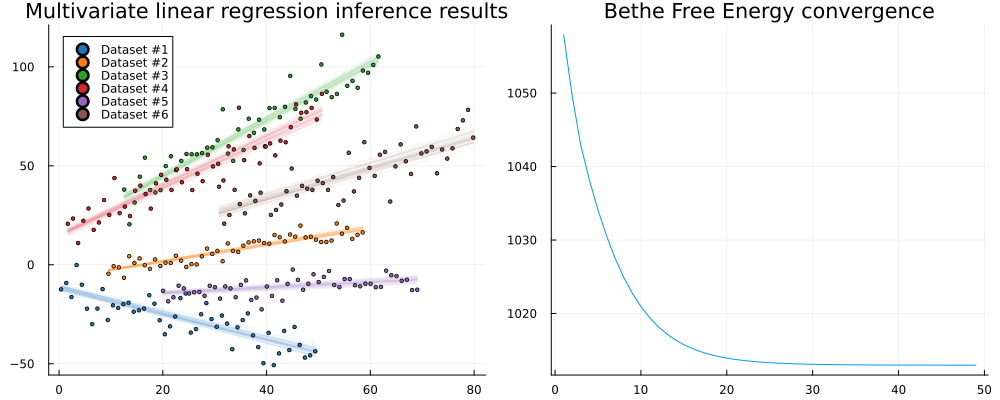

In [296]:
p = plot(title = "Multivariate linear regression inference results", legend = :topleft)

# how many lines to plot
r = 50

i_a = collect.(eachcol(rand(results_mv.posteriors[:a], r)))
i_b = collect.(eachcol(rand(results_mv.posteriors[:b], r)))

plt = palette(:tab10)

for k in 1:d_mv
    x_mv_k = x_mv[k]
    y_mv_k = y_mv[k]

    for i in 1:r
        global p = plot!(p, x_mv_k, x_mv_k .* i_a[i][k] .+ i_b[i][k], label = nothing, alpha = 0.05, color = plt[k])
    end

    global p = scatter!(p, x_mv_k, y_mv_k, label = "Dataset #$k", ms = 2, color = plt[k])
end

# truncate the init step
f = plot(results_mv.free_energy[2:end], title ="Bethe Free Energy convergence", label = nothing) 

plot(p, f, size = (1000, 400))

We needed more iterations to converge, but that is expected since the problem became multivariate and, hence, more difficult.

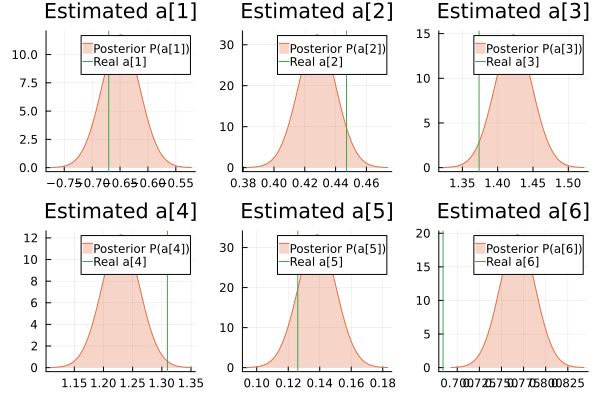

In [297]:
i_a_mv = results_mv.posteriors[:a]

ps_a = []

for k in 1:d_mv
    
    local _p = plot(title = "Estimated a[$k]")
    local m_a_mv_k = mean(i_a_mv)[k]
    local v_a_mv_k = std(i_a_mv)[k, k]
    
    _p = plot!(_p, Normal(m_a_mv_k, v_a_mv_k), fillalpha=0.3, fillrange = 0, label="Posterior P(a[$k])", c=2,)
    _p = vline!(_p, [ a_mv[k] ], label="Real a[$k]", c = 3)
           
    push!(ps_a, _p)
end

plot(ps_a...)

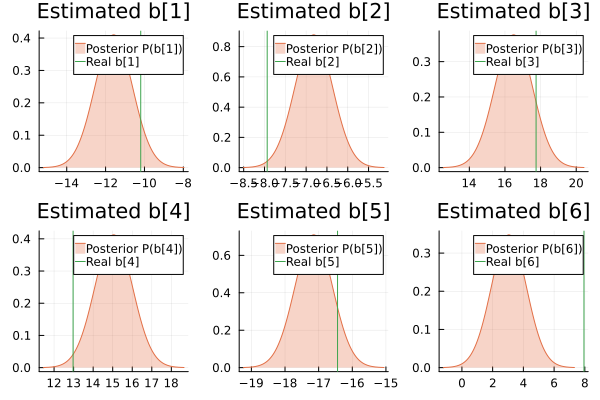

In [298]:
i_b_mv = results_mv.posteriors[:b]

ps_b = []

for k in 1:d_mv
    
    local _p = plot(title = "Estimated b[$k]")
    local m_b_mv_k = mean(i_b_mv)[k]
    local v_b_mv_k = std(i_b_mv)[k, k]

    _p = plot!(_p, Normal(m_b_mv_k, v_b_mv_k), fillalpha=0.3, fillrange = 0, label="Posterior P(b[$k])", c=2,)
    _p = vline!(_p, [ b_mv[k] ], label="Real b[$k]", c = 3)
           
    push!(ps_b, _p)
end

plot(ps_b...)

As we can also check the noise estimation procedure found the noise components with high precision:

In [299]:
v_mv

6-element Vector{Float64}:
 63.75837562301017
 11.035887151354174
 59.851445480565424
 32.21105133173212
 16.228513601930295
 64.33685320974074

In [300]:
diag(mean(results_mv.posteriors[:W]))

6-element Vector{Float64}:
 46.84286457476093
 10.133442136520724
 56.09378701616542
 47.51512652020515
 15.868894384162314
 74.52960976901755